
**<h1><span style="color:red"><u>Fraud</u></span></h1>**
**Réalisé par : Toullec Nastassia, Marie Stéphanie et Abdelaziz Sayad**

### <span style="color:yellow"> 0. Importation des librairies</span> 

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency 
import warnings
from scipy.stats import pearsonr
import statsmodels.api
warnings.filterwarnings('ignore')
%matplotlib inline

## <span style="color:red"> I. Audit des données</span> 

Le jeu de données que nous allons utiliser, recense diverses caractéristiques d'utilisateurs et leur transactions.
Le but de notre audit est de predire si une transaction est fraudeuse.

Le dataset comporte <strong>11 colonnes</strong>, pour environ <strong>151113 lignes</strong>.
Les variables sont les suivantes :

- <strong>user_id</strong>	identifiant d'utilisateur
- <strong>signup_time</strong>	heure de connexion
- <strong>purchase_time</strong>	heure d'achat
- <strong>purchase_value</strong>	montant de la transaction
- <strong>device_id</strong>	identifiant du moyen de connexion
- <strong>source</strong>	moyen d'accés au site
- <strong>browser</strong>	navigateur utilisé
- <strong>sex</strong>	sexe
- <strong>age</strong>	age
- <strong>ip_adress</strong>	adresse IP de l'utilisateur
- <strong>is_fraud</strong>	variable cible: identifiant de la fraud

Le jeu de données qui nous intéresse ici contient dix variables explicatives.
La variable expliquée est <strong>is_fraud</strong> soit 0 non frauduleux et des 1 pour frauduleux . 
La problématique est la clasification avec apprentissage supervisé.

### <span style="color:blue"> **A. Exploration un jeu de données**</span> 

<span style="color:green"> **1. Chargement des données**</span> 

Nous chargeons les données et affichons les premières lignes.

In [2]:
df = pd.read_csv(filepath_or_buffer = 'fraud.csv',
                           sep = ',',
                           header = 0)
df.head(10)                    

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 3:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 7:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


<span style="color:green"> **2. Nettoyage du jeu de données**</span> 

<strong>Nous recréons les variables temporelles pour analyser la temporalité des données.</strong>

1/ Les variables signup_time et purchase_time, sont divisées chacune par date et heure, nous permettant de créer 4 variables supplémentaires :
<ul>
    <li>signup_day</li>
    <li>signup_time</li>
    <li>purchase_day</li>
    <li>purshase_time</li>
</ul>

In [3]:
#Les variables signup_time et purchase_time se composent des dates avec les heures, 
#pour mieux visualiser ces donnés on va les séparer
df['signup_day'] = df['signup_time'].apply(lambda time: time.split( )[0])
df['signup_time'] = df['signup_time'].apply(lambda time: time.split( )[1])
df['purchase_day'] = df['purchase_time'].apply(lambda time: time.split( )[0])
df['purchase_time'] = df['purchase_time'].apply(lambda time: time.split( )[1]) 

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015-02-24,2015-04-18
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015-06-07,2015-06-08
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015-01-01,2015-01-01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015-04-28,2015-05-04
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015-07-21,2015-09-09


2/ puis nous divisons chacune des variables signup_day et purchase_day en 3 variables distinctes.
Ainsi la date de connexion se compose de :
<ul>
    <li>signup_day</li>
    <li>signup_month</li>
    <li>signup_year</li>
</ul> 

Pour la date d'achat : 

<ul>
    <li>purchase_day</li>
    <li>purchase_month</li>
    <li>purchase_year</li>
</ul> 

Cette ventilation nous permettra d'analyser et détecter les tendances des transactions dans le temps.

In [4]:
df['signup_year'] = df['signup_day'].apply(lambda date: date.split('-')[0])
df['signup_month'] = df['signup_day'].apply(lambda date: date.split('-')[1])
df['signup_day'] = df['signup_day'].apply(lambda date: date.split('-')[2])


df['purchase_year'] = df['purchase_day'].apply(lambda date: date.split('-')[0])
df['purchase_month'] = df['purchase_day'].apply(lambda date: date.split('-')[1])
df['purchase_day'] = df['purchase_day'].apply(lambda date: date.split('-')[2])

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day,signup_year,signup_month,purchase_year,purchase_month
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,24,18,2015,02,2015,04
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,07,08,2015,06,2015,06
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,01,01,2015,01,2015,01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,28,04,2015,04,2015,05
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,21,09,2015,07,2015,09


Nous mettons les variables dans l'ordre pour une meilleure lecture.

In [5]:
df = df[['user_id','signup_time','signup_day', 'signup_month', 'signup_year',
        'purchase_time','purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'device_id','source','browser','sex', 'age','ip_address','is_fraud']]


df.head()

,user_id,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,22:55:49,24,02,2015,2:47:11,18,04,2015,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,20:39:50,07,06,2015,1:38:54,08,06,2015,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,18:52:44,01,01,2015,18:52:45,01,01,2015,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,21:13:25,28,04,2015,13:54:50,04,05,2015,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7:09:52,21,07,2015,18:40:53,09,09,2015,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<strong>Nous vérifions les valeurs éventuellement manquantes.</strong>

In [6]:
df.isna().sum() #affichez les valeurs manquantes
#Il n'y a pas de valeurs manquantes

user_id           0
signup_time       0
signup_day        0
signup_month      0
signup_year       0
purchase_time     0
purchase_day      0
purchase_month    0
purchase_year     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

Le jeu de données de contient pas de valeurs manquantes

<strong>Nous vérifions les doublons</strong>

In [8]:
print('Lignes de transactions dupliquées:',df.duplicated().sum())

print('Doublons sur les user id:',df['user_id'].duplicated().sum())
print('Doublons sur les adresse ip:' ,df['ip_address'].duplicated().sum())
print('Doublons sur les device id:',df['device_id'].duplicated().sum())

Lignes de transactions dupliquées: 0
Doublons sur les user id: 0
Doublons sur les adresse ip: 7601
Doublons sur les device id: 13156


Il n y a pas de globalement de doublons sur les lignes de transactions, nous noterons l'existence de doublons sur les adresses ip et les devices id, malgré l'absence de doublons sur les user id. Nous pourrons analyser ces données ultérieurement.

<span style="color:green"> **3. Analyse descriptive des données**</span> 

Le jeu de données se compose ainsi : 

In [9]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   signup_day      151112 non-null  object 
 3   signup_month    151112 non-null  object 
 4   signup_year     151112 non-null  object 
 5   purchase_time   151112 non-null  object 
 6   purchase_day    151112 non-null  object 
 7   purchase_month  151112 non-null  object 
 8   purchase_year   151112 non-null  object 
 9   purchase_value  151112 non-null  int64  
 10  device_id       151112 non-null  object 
 11  source          151112 non-null  object 
 12  browser         151112 non-null  object 
 13  sex             151112 non-null  object 
 14  age             151112 non-null  int64  
 15  ip_address      151112 non-null  float64
 16  is_fraud        151112 non-null  int64  
dtypes: float64

<strong>Analyse descriptives des variables quantitatives</strong>

Les données numériques sont globalement distribuées de la façon suivantes : 

In [10]:
df.describe() #la distribution des données

,user_id,purchase_value,age,ip_address,is_fraud
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Pour une analyse plus poussée, nous nous pencherons sur l'analyse descriptives des variables quantitatives <strong>age</strong> et <strong>purchase_value</strong>. Les variables user_id, ip_adresse étant des identifiants et is_fraud une variable binaire, n'entrent pas pour l'instant dans le scope d'analyse.

In [48]:
print(df.duplicated().sum())

num_data = df[['purchase_value','age']]


stats = pd.DataFrame(num_data.median(), columns = ['mediane'])
stats['moyenne'] = num_data.mean()

stats['moyenne - ecart type'] = pd.DataFrame(num_data.mean() - num_data.std())

stats['moyenne + ecart type'] = pd.DataFrame(num_data.mean() +  num_data.std())


stats.round(2)

0


,mediane,moyenne,moyenne - ecart type,moyenne + ecart type
purchase_value,35.0,36.94,18.61,55.26
age,33.0,33.14,24.52,41.76


In [61]:
#could be interesting to see 'l'ecart type' separately from varaibles, no?
#Une mesure de la dispersion des valeurs
ecart_type_pv = num_data['purchase_value'].std()
ecart_type_a = num_data['age'].std()

print(ecart_type_pv, ecart_type_a)

18.322762148660615 8.617733490959177


Statistiques valeurs d'achats avec/sans fraude: 

In [11]:
purchase_value_by_fraud = df.groupby(['is_fraud']).agg({'purchase_value':['sum','mean','median','min','max']})

purchase_value_by_fraud

purchase_value                           
                    sum       mean median min  max
is_fraud                                          
0               5057890  36.929418   35.0   9  154
1                523488  36.993004   35.0   9  111

Statistiques sur l''âge des individus  avec/sans fraude:

In [12]:
age_by_fraud = df.groupby(['is_fraud']).agg({'age':['mean','median','min','max']})
age_by_fraud

age               
               mean median min max
is_fraud                          
0         33.122356   33.0  18  76
1         33.318281   33.0  18  68

La moyenne et la médiane des variables age et purchase_value sont très proches, les valeurs sont plutôt homogènes.

Pour analyser la dispersion des valeurs, nous avons déterminer l'intervalle (moyenne -/+ ecart type) dans lequel les valeurs sont au plus proche de la moyenne.

Nous allons par ailleurs déterminer la proportions de valeurs présentes ou non dans cet intervalle.

In [59]:

num_data['purchase_value_in'] = num_data['purchase_value'].between(stats['moyenne - ecart type'][0], stats['moyenne + ecart type'][0]).astype(int)
print('Dispersion des achats\n',num_data['purchase_value_in'].value_counts(normalize=True))

outliers_purchase_value = num_data[num_data.purchase_value_in==0]

num_data['purchase_value_in'] = outliers_purchase_value['purchase_value'].mean()#should we delete it?


print('Achat moyen et médian en dehos de l\'intervalle:',outliers_purchase_value['purchase_value'].mean(), outliers_purchase_value['purchase_value'].median())

num_data['age_in'] = num_data['age'].between(stats['moyenne - ecart type'][1], stats['moyenne + ecart type'][1]).astype(int)

print('Dispersion des âges \n',num_data['age_in'].value_counts(normalize=True))
      
outliers_age = num_data[num_data.age_in==0]

print('age moyen et median en dehors de l\'intervalle :', outliers_age['age'].mean(), outliers_age['age'].median())


Dispersion des achats
 1    0.664414
0    0.335586
Name: purchase_value_in, dtype: float64
Achat moyen et médian en dehos de l'intervalle: 39.93602965825955 18.0
Dispersion des âges 
 1    0.653826
0    0.346174
Name: age_in, dtype: float64
age moyen et median en dehors de l'intervalle : 33.967406472825985 24.0


Nous constatons que près de 33-34 % des achats et d'individus selon leur age sont dispersés dans le jeu de données

Les achats moyens des valeurs extrêmes sont plus elevées que la moyenne globale contrairement à la mediane des valeurs extrêmes qui est plus basse que la médiane globale.

<strong>Relation entre les variables quantitatives et la variable is_fraud</strong>

In [65]:
#Une dernière étape consiste à étudier les relations entre variables quantitatives et qualitatives.

df[['purchase_value','age']].corr()

,purchase_value,age
purchase_value,1.00000,0.00237
age,0.00237,1.00000


In [64]:
cof,pvalue = pearsonr(df['purchase_value'], df['age'])

print(cof)#the same as in the table?

print(pvalue)#the same as in the table?

print(pd.DataFrame(pearsonr(df['purchase_value'], df['age']), index=['pearson_coeff','p-value'], columns=['purchase_']))


0.0023698179233696687
0.3569376648847938
               purchase_
pearson_coeff   0.002370
p-value         0.356938


la p-value est > 5%, le coefficient est proche de null, il n y a pas de corrélation entre les variables age et purchase_value.
Ces variables sont indépendantes.

In [16]:
result = statsmodels.formula.api.ols('age ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table


,df,sum_sq,mean_sq,F,PR(>F)
is_fraud,1.0,4.923416e+02,492.341625,6.629742,0.01003
Residual,151110.0,1.122182e+07,74.262564,NaN,NaN


La p-value (PR(>F)) est inférieur à 5% donc on rejette l'hypothèse selon laquelle is_fraud n'influe pas sur l'age.

In [17]:
result = statsmodels.formula.api.ols('purchase_value ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
is_fraud,1.0,5.185735e+01,51.857354,0.154464,0.694306
Residual,151110.0,5.073148e+07,335.725491,NaN,NaN


la p-value (PR(>F)) est supérieur à 5% donc l'hypothèse selon laquelle is_fraud n'influe pas sur purchase_value est confirmée.

In [18]:
#Histogramme

<strong>Analyse descriptives des variables qualitatives</strong>

On détermine les variables catégorielles et on les stocke dans un tableau cat_data:

In [11]:
cat_data  = df.select_dtypes(include = 'O')
cat_data['user_id'] = df['user_id']
cat_data['ip_address'] = df['ip_address']
cat_data['is_fraud'] = df['is_fraud']

cat_data

,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,device_id,source,browser,sex,user_id,ip_address,is_fraud
0,22:55:49,24,02,2015,2:47:11,18,04,2015,QVPSPJUOCKZAR,SEO,Chrome,M,22058,7.327584e+08,0
1,20:39:50,07,06,2015,1:38:54,08,06,2015,EOGFQPIZPYXFZ,Ads,Chrome,F,333320,3.503114e+08,0
2,18:52:44,01,01,2015,18:52:45,01,01,2015,YSSKYOSJHPPLJ,SEO,Opera,M,1359,2.621474e+09,1
3,21:13:25,28,04,2015,13:54:50,04,05,2015,ATGTXKYKUDUQN,SEO,Safari,M,150084,3.840542e+09,0
4,7:09:52,21,07,2015,18:40:53,09,09,2015,NAUITBZFJKHWW,Ads,Safari,M,221365,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,3:03:34,27,01,2015,0:30:47,29,03,2015,XPSKTWGPWINLR,SEO,Chrome,M,345170,3.451155e+09,1
151108,17:43:29,15,05,2015,12:24:39,26,05,2015,LYSFABUCPCGBA,SEO,Safari,M,274471,2.439047e+09,0
151109,23:07:31,03,03,2015,7:07:47,20,05,2015,MEQHCSJUBRBFE,SEO,IE,F,368416,2.748471e+09,0
151110,20:06:07,09,07,2015,9:34:46,07,09,2015,CMCXFGRHYSTVJ,SEO,Chrome,M,207709,3.601175e+09,0


On regarde les modalités les plus fréquentes des variables qualitatives et comment se répartissent-elles:

In [117]:
print(cat_data['is_fraud'].value_counts())
print('\n')
print(cat_data['is_fraud'].value_counts(normalize=True))
#9,3 % transactions sont fraudeause

0    136961
1     14151
Name: is_fraud, dtype: int64


0    0.906354
1    0.093646
Name: is_fraud, dtype: float64


In [116]:
print(cat_data['device_id'].value_counts().head())
print('\n')
print(cat_data['device_id'].mode())#Nous avons 6 id qui ont fait max d'achats = 20 chacun

CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
EQYVNEGOFLAWK    20
ZUSVMDEZRBDTX    20
NGQCKIADMZORL    20
Name: device_id, dtype: int64


0    CQTUVBYIWWWBC
1    EQYVNEGOFLAWK
2    ITUMJCKWEYNDD
3    KIPFSCNUGOLDP
4    NGQCKIADMZORL
5    ZUSVMDEZRBDTX
Name: device_id, dtype: object


In [16]:
print(cat_data['ip_address'].value_counts().head())
print('\n')
print(cat_data['ip_address'].mode())#4 ip_address qui ont fait max d'achats = 20 chacun

3.874758e+09    20
2.050964e+09    20
5.760609e+08    20
1.502818e+09    20
1.797069e+09    19
Name: ip_address, dtype: int64


0    5.760609e+08
1    1.502818e+09
2    2.050964e+09
3    3.874758e+09
Name: ip_address, dtype: float64


In [118]:
print(cat_data['source'].value_counts(normalize=True))
print('\n')
print(cat_data['source'].mode())#On récupére la modalité la plus fréquente: SEO

SEO       0.401126
Ads       0.396269
Direct    0.202605
Name: source, dtype: float64


0    SEO
Name: source, dtype: object


In [119]:
print(cat_data['browser'].value_counts(normalize=True))
print('\n')
print(cat_data['browser'].mode())#On récupére la modalité la plus fréquente: Chrome

Chrome     0.406533
IE         0.243045
Safari     0.163237
FireFox    0.162859
Opera      0.024326
Name: browser, dtype: float64


0    Chrome
Name: browser, dtype: object


In [120]:
print(cat_data['sex'].value_counts(normalize=True))
print('\n')
print(cat_data['sex'].mode())#On récupére la modalité la plus fréquente :homme

M    0.584288
F    0.415712
Name: sex, dtype: float64


0    M
Name: sex, dtype: object


In [121]:
print(cat_data['signup_day'].value_counts(normalize=True))
print('\n')
print(cat_data['signup_day'].mode())#On récupére la modalité la plus fréquente :day 07

07    0.038905
02    0.038025
12    0.037985
08    0.037707
01    0.037370
10    0.037237
06    0.037151
11    0.037151
03    0.036767
05    0.036655
04    0.036628
09    0.036311
13    0.033889
17    0.033816
14    0.033108
16    0.033075
15    0.032810
18    0.029773
25    0.029342
19    0.029323
23    0.029104
21    0.029012
27    0.028899
24    0.028754
26    0.028701
20    0.028628
22    0.028608
28    0.028581
29    0.024935
30    0.024697
31    0.017054
Name: signup_day, dtype: float64


0    07
Name: signup_day, dtype: object


In [122]:
print(cat_data['purchase_day'].value_counts(normalize=True))
print('\n')
print(cat_data['purchase_day'].mode())#On récupére la modalité la plus fréquente :day 07

07    0.035987
11    0.035861
06    0.035854
04    0.035417
08    0.035384
02    0.035331
12    0.035245
05    0.034895
10    0.034881
09    0.034696
03    0.034597
01    0.034577
13    0.032248
20    0.032175
26    0.031970
19    0.031798
28    0.031685
18    0.031678
22    0.031533
23    0.031394
15    0.031387
21    0.031281
17    0.031215
27    0.031215
14    0.031209
25    0.030865
16    0.030772
24    0.030381
29    0.029071
30    0.028131
31    0.017265
Name: purchase_day, dtype: float64


0    07
Name: purchase_day, dtype: object


On affiche des histogrammes pour mieux comprendre la distribution des données. Pour bien voir les résultats on les separe en 3 parties.

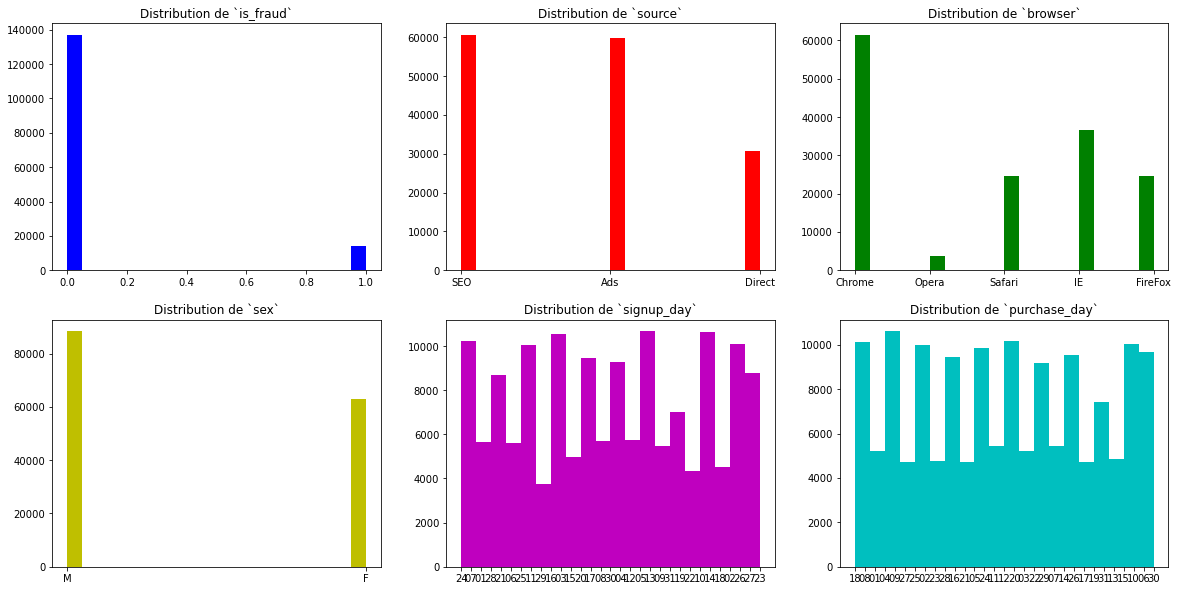

In [128]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0][0].hist(df['is_fraud'], color='b', bins=20)
axes[0][0].set_title('Distribution de `is_fraud`')
axes[0][1].hist(df['source'], color='r', bins=20)
axes[0][1].set_title('Distribution de `source`')
axes[0][2].hist(df['browser'], color='g', bins=20)
axes[0][2].set_title('Distribution de `browser`')

axes[1][0].hist(df['sex'], color='y', bins=20)
axes[1][0].set_title('Distribution de `sex`')
axes[1][1].hist(df['signup_day'], color='m', bins=20)
axes[1][1].set_title('Distribution de `signup_day`')
axes[1][2].hist(df['purchase_day'], color='c', bins=20)
axes[1][2].set_title('Distribution de `purchase_day`')

plt.show()

device_id
CQTUVBYIWWWBC    19
EQYVNEGOFLAWK    19
ITUMJCKWEYNDD    19
KIPFSCNUGOLDP    19
NGQCKIADMZORL    19
                 ..
ZZHQSPRTPEPHI     1
ZZJGHWLIVVIIS     1
ZZMFOPGWVVSHV     1
ZZQBRNNATFEIW     1
ZZUBRTQITHWAO     1
Name: device_id, Length: 6987, dtype: int64


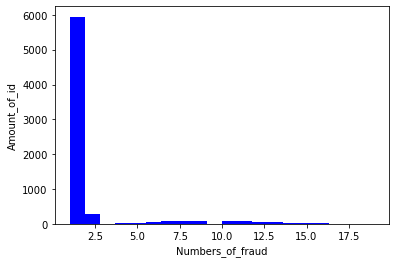

In [27]:
max_fraud_id = df.groupby('is_fraud').device_id.value_counts()[1, :]#combien frauds par ID
print(max_fraud_id)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_id, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

Pour mieux visualiser, on affiche à partir de 3 frauds:

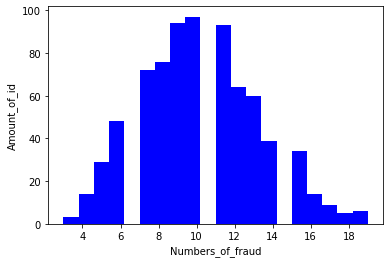

In [18]:
max_fraud_id_more3 = []
for i in max_fraud_id:
    if i >= 3:
        max_fraud_id_more3.append(i)

plt.hist(max_fraud_id_more3, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

ip_address
3.484934e+08    19
5.760609e+08    19
1.502818e+09    19
2.050964e+09    19
3.874758e+09    19
                ..
4.290932e+09     1
4.292392e+09     1
4.292424e+09     1
4.293762e+09     1
4.294131e+09     1
Name: ip_address, Length: 7277, dtype: int64


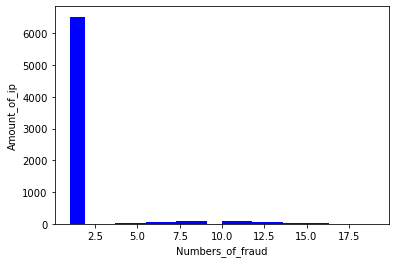

In [31]:
max_fraud_ip = df.groupby('is_fraud').ip_address.value_counts()[1, :]#combien frauds par ip_address
print(max_fraud_ip)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_ip, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

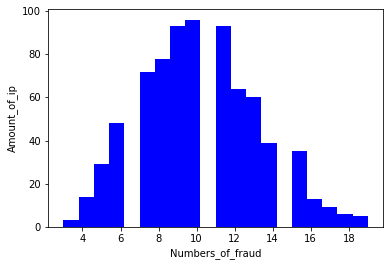

In [33]:
#Pour mieux visualiser, on affiche à partir de 3 frauds
max_fraud_ip_more3 = []
for i in max_fraud_ip:
    if i >= 3:
        max_fraud_ip_more3.append(i)

plt.hist(max_fraud_ip_more3, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

Pour nos variables qualitatives on va utiliser la table de contingence. On appelle une table de contingence, la table croisée contenant les différentes catégories des deux variables en question. Pour afficher une table de contingence, on utilise la fonction crosstab avec les deux variables en argument. Cette table de contingence permet de visualiser comment se distribuent les catégories de la variable 1 au sein de la variable 2. Pour des variables totalement indépendantes, la distribution doit être proportionnelle entre chaque ligne et entre chaque colonne.

In [76]:
print(pd.crosstab(df['device_id'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['ip_address'],df['is_fraud']))
print('\n')

print(pd.crosstab(df['source'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['browser'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['sex'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['signup_day'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['purchase_day'],df['is_fraud']))


is_fraud       0   1
device_id           
AAALBGNHHVMKG  1   0
AAAWIHVCQELTP  1   0
AAAXJHWCLISKY  1   0
AAAXXOZJRZRAO  1  10
AABFGRPBQHWFQ  1   0
...           ..  ..
ZZZGSIJRNCXBJ  1   0
ZZZIKLJSVSQMF  1   0
ZZZKJIZHJEDFN  1   0
ZZZMVOGBAJVTM  1   0
ZZZXASJUVUNMV  1   0

[137956 rows x 2 columns]


is_fraud      0  1
ip_address        
5.209350e+04  1  0
9.344714e+04  1  0
1.058185e+05  1  0
1.175667e+05  1  0
1.314238e+05  1  0
...          .. ..
4.294674e+09  1  0
4.294715e+09  1  0
4.294720e+09  1  0
4.294822e+09  1  0
4.294850e+09  1  0

[143511 rows x 2 columns]


is_fraud      0     1
source               
Ads       54368  5513
Direct    27390  3226
SEO       55203  5412


is_fraud      0     1
browser              
Chrome    55363  6069
FireFox   22268  2342
IE        33540  3187
Opera      3348   328
Safari    22442  2225


is_fraud      0     1
sex                  
F         57102  5717
M         79859  8434


is_fraud       0    1
signup_day           
01          4841  80

Le test qu'on effectue alors est un test du  χ2  par table de contingence.
Pour chaque case d'un tableau, il effectue un test du  χ2 (test de proportions) entre l'effectif de la case et l'effectif total de la colonne.
La statistique de test est alors obtenue en faisant la somme de toutes ces statistiques.

Pour ce test, on pose comme les hypothèses nulles :
1."les variables device_id et is_fraud sont indépendantes" 
2."les variables ip_address et is_fraud sont indépendantes"
3."les variables source et state is_fraud indépendantes" 
4."les variables browser et state is_fraud indépendantes" 
5."les variables sex et state is_fraud indépendantes" 
6."les variables signup_day et is_fraud sont indépendantes"
7."les variables purchase_day et is_fraud sont indépendantes" 

Ce test peut s'effectuer tout simplement grâce à la fonction chi2_contingency de scipy appliquée à la table de contingence.
Elle renvoie un array de 4 éléments : la statistique du test, la p-value, le degré de liberté et la liste des fréquences attendues. Pour rejeter l'hypothèse nulle, il est nécessaire que la p-value soit inférieure à 5%.

In [93]:
#L'hypothèse nulle №1
table1=pd.crosstab(df['device_id'],df['is_fraud'])
resultats_test = chi2_contingency(table1)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

131422.8 1.0 137955


In [94]:
#L'hypothèse nulle №2
table2=pd.crosstab(df['ip_address'],df['is_fraud'])
resultats_test = chi2_contingency(table2)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

143413.2 0.5712286437051614 143510


In [103]:
#L'hypothèse nulle №3
table3=pd.crosstab(df['source'],df['is_fraud'])
resultats_test = chi2_contingency(table3)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value > 5% donc on accepte H0

64.9 7.981990836440143e-15 2


In [104]:
#L'hypothèse nulle №4
table4=pd.crosstab(df['browser'],df['is_fraud'])
resultats_test = chi2_contingency(table4)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value presque 5% donc on rejette H0

44.6 4.916028350364759e-09 4


In [105]:
#L'hypothèse nulle №5
table5=pd.crosstab(df['sex'],df['is_fraud'])
resultats_test = chi2_contingency(table5)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

8.8 0.003072654263243465 1


In [106]:
#L'hypothèse nulle №6
table6=pd.crosstab(df['signup_day'],df['is_fraud'])
resultats_test = chi2_contingency(table6)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

5031.5 0.0 30


In [107]:
#L'hypothèse nulle №7
table7=pd.crosstab(df['purchase_day'],df['is_fraud'])
resultats_test = chi2_contingency(table7)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

5446.1 0.0 30


Comme pour les variables quantitatives, on peut mesurer le niveau de corrélation entre deux variables qualitatives. Pour cela, on utilise le V de Cramer corrigé pour contrer le biais qui utilise les résultats du test du  χ2. Il renvoie une valeur entre 0 et 1.

In [95]:
def V_Cramer(table1, N):
    stat_chi2 = chi2_contingency(table1)[0]
    k = table1.shape[0]
    r = table1.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table1, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre les deux variables.

0.0

In [97]:
def V_Cramer(table2, N):
    stat_chi2 = chi2_contingency(table2)[0]
    k = table2.shape[0]
    r = table2.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table2, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre les deux variables.

0.0

In [108]:
def V_Cramer(table3, N):
    stat_chi2 = chi2_contingency(table3)[0]
    k = table3.shape[0]
    r = table3.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table3, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre les deux variables.

0.020405969624040766

In [109]:
def V_Cramer(table4, N):
    stat_chi2 = chi2_contingency(table4)[0]
    k = table4.shape[0]
    r = table4.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table4, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre les deux variables.

0.016382585261164186

In [110]:
def V_Cramer(table5, N):
    stat_chi2 = chi2_contingency(table5)[0]
    k = table5.shape[0]
    r = table5.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table5, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre les deux variables.

0.007167858133544223

In [112]:
def V_Cramer(table6, N):
    stat_chi2 = chi2_contingency(table6)[0]
    k = table6.shape[0]
    r = table6.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table6, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre les deux variables mais qu'elle n'est pas non plus négligeable.

0.18192984899342954

In [113]:
def V_Cramer(table7, N):
    stat_chi2 = chi2_contingency(table7)[0]
    k = table7.shape[0]
    r = table7.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table7, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre les deux variables mais qu'elle n'est pas non plus négligeable.

0.18931890046383054

<span style="color:green"> **4. Modelisation**</span> 

On peut constater que notre variable cible 'is_fraud' est déséquilibrée, on va utiliser oversampling pour resoudre ce problème. Il y a plusiers methods de suréchantillonnage, l'analyse de nos donées nous dirige vers une méthode SMOTE.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène nos donées minoritaires.

C’est sur ces données transformées, que l’on va ensuite entraîner un modèle de Machine Learning.



In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE


#On sépare les variables explicatives de df dans un Dataframe X et la variable cible dans une Series y.
X = df.drop(["is_fraud"], axis = 1)
y = df['is_fraud']


# summarize our class distribution
counter = Counter(y)
print(counter)

# transform the dataset ------------> une erreur
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

#plot 

plt.hist(y);